# check the robustness of low dimensionality reduction method (factor analysis: pure latent/ reconstructed share space/ reconstructed private space) in classification across day. Compared the classification results with only pure feature of (HG). Task: cross validate a single good/bad day into a trained classifier generated using all other days.


# Organzing and loading the data for all related days 

In [2]:
# clean the memory 


# loading the library
import numpy as np
import os
import os.path
import scipy.io
from scipy.io import loadmat
import pickle
import hdf5storage as hdf5s
import h5py

# Experiment info 
# loading the imagined data

# initilize the values
class structtype():
    pass

ExptDays = list(['20201002','20201009','20201016','20201030','20201113','20201117','20201118','20201125','20201211'])
NumDay = len(ExptDays);
SessionDay = [ structtype() for i in range(NumDay)]
SessionDay[0].hhmmss = list(['145058','145910','150443','151528','152108'])
SessionDay[1].hhmmss = list(['134342','134836','135450','135947'])
SessionDay[2].hhmmss = list(['142924','144138','144924'])
SessionDay[3].hhmmss = list(['133902','134541','134838','141625','142426'])
SessionDay[4].hhmmss = list(['134350','135330','135938','140554'])
SessionDay[5].hhmmss = list(['111747','112508','113040','141009'])
SessionDay[6].hhmmss = list(['140255','140540'])
SessionDay[7].hhmmss = list(['105228','111217','112507','112711','113526','114108','143218','143824'])
SessionDay[8].hhmmss = list(['114458','114725'])

# for reading mat file from matlab
# it is easier to use class for further extracting necessary params or data
class MatFileAnalyzer():
    
    # first mandatory method; constructor
    def __init__(self,Mat_data):
        self.Fs = Mat_data['TrialData']['Params']['Fs'][0][0]
        self.UpdateRate = Mat_data['TrialData']['Params']['UpdateRate'][0][0]
        self.TargetID = Mat_data['TrialData']['TargetID'][0][0]
        self.SelectedTargetID = Mat_data['TrialData']['SelectedTargetID'][0][0]
        self.MaxReachTime = Mat_data['TrialData']['Params']['MaxReachTime'][0][0]
        self.Click_BinNum = Mat_data['TrialData']['Params']['ClickCounter'][0][0]
        
    def ECoG_Raw(self):
        
        Signals = Mat_data['TrialData']['BroadbandData']
        BinNum = Signals.shape[0]
        ECoGData = np.empty((0,128), dtype=float)
        for i in range(BinNum):
            Bin = Mat_data['TrialData']['BroadbandData'][i][0]
            BinName = h5py.h5r.get_name(Bin, Mat_data.id)
            BinInfo = Mat_data[BinName] 
            BinData = BinInfo[:,:]
            ECoGData = np.concatenate((ECoGData, BinData.T), axis=0)

        return ECoGData
    
    def Features_All(self):
        
        Features = Mat_data['TrialData']['NeuralFeatures']
        BinNum = Features.shape[0]
        NeuralFeatures = np.empty((0,896), dtype=float)
        
        if ExptDays[Day] == '20201002':
            
            for i in range(BinNum-int(self.Click_BinNum),BinNum,1):
                Bin = Mat_data['TrialData']['NeuralFeatures'][i][0]
                BinName = h5py.h5r.get_name(Bin, Mat_data.id)
                BinInfo = Mat_data[BinName] 
                BinData = BinInfo[:,:]
                NeuralFeatures = np.concatenate((NeuralFeatures, BinData), axis=0)
                
            return NeuralFeatures
        
        else:
                        
            BinControl = [] 
            for i in range(BinNum):
                if Mat_data['TrialData']['TaskState'][i][0] == 3:
                    BinControl.append(i)
            #endfor
            
            for j in BinControl[-int(TrialData.Click_BinNum):]:
                if ExptDays[Day] == '20201009':
                    j=j-1
                    
                Bin = Mat_data['TrialData']['NeuralFeatures'][j][0]
                BinName = h5py.h5r.get_name(Bin, Mat_data.id)
                BinInfo = Mat_data[BinName] 
                BinData = BinInfo[:,:]
                NeuralFeatures = np.concatenate((NeuralFeatures, BinData), axis=0)
            #endfor
            
            return NeuralFeatures
        
    def SmoothedFeatures_All(self):
        
        Features = Mat_data['TrialData']['SmoothedNeuralFeatures']
        BinNum = Features.shape[0]
        SmoothedNeuralFeatures = np.empty((0,896), dtype=float)
                  
        BinControl = [] 
        for i in range(BinNum):
            if Mat_data['TrialData']['TaskState'][i][0] == 3:
                BinControl.append(i)
        
        #endfor
        
        for j in BinControl[-int(TrialData.Click_BinNum):]:
            if ExptDays[Day] == '20201009':
                j=j-1

            Bin = Mat_data['TrialData']['SmoothedNeuralFeatures'][j][0]
            BinName = h5py.h5r.get_name(Bin, Mat_data.id)
            BinInfo = Mat_data[BinName] 
            BinData = BinInfo[:,:]
            SmoothedNeuralFeatures = np.concatenate((SmoothedNeuralFeatures, BinData), axis=0)
        
        #endfor
        
        return SmoothedNeuralFeatures
    
    def SmoothedFeatures_All_Fail(self):
        
        Features = Mat_data['TrialData']['SmoothedNeuralFeatures']
        BinNum = Features.shape[0]
        SmoothedNeuralFeatures = np.empty((0,896), dtype=float)
                  
        BinControl = [] 
        for i in range(BinNum):
            if Mat_data['TrialData']['TaskState'][i][0] == 3:
                BinControl.append(i)

        for j in BinControl:
            if ExptDays[Day] == '20201009':
                j=j-1

            Bin = Mat_data['TrialData']['SmoothedNeuralFeatures'][j][0]
            BinName = h5py.h5r.get_name(Bin, Mat_data.id)
            BinInfo = Mat_data[BinName] 
            BinData = BinInfo[:,:]
            SmoothedNeuralFeatures = np.concatenate((SmoothedNeuralFeatures, BinData), axis=0)

        return SmoothedNeuralFeatures
    

# initialzing the trial values per day
Trials_T1 = np.empty((0,896), dtype=float)
Trials_T2 = np.empty((0,896), dtype=float)
Trials_T3 = np.empty((0,896), dtype=float)
Trials_T4 = np.empty((0,896), dtype=float)

Trials_Fail_T1 = np.empty((0,896), dtype=float)
Trials_Fail_T2 = np.empty((0,896), dtype=float)
Trials_Fail_T3 = np.empty((0,896), dtype=float)
Trials_Fail_T4 = np.empty((0,896), dtype=float)

# numnber of censequative bins for making correct selections
Click_BinNum_T1 = []
Click_BinNum_T2 = []
Click_BinNum_T3 = []
Click_BinNum_T4 = []

Day_NumTrial_T1 = []
Day_NumTrial_T2 = []
Day_NumTrial_T3 = []
Day_NumTrial_T4 = []

Day_NumTrial_Fail_T1 = []
Day_NumTrial_Fail_T2 = []
Day_NumTrial_Fail_T3 = []
Day_NumTrial_Fail_T4 = []

# initializing the structure type
TrialsData = [ structtype() for day in range(8)]
for day in range(8):
    TrialsData[day].Target = [ structtype() for TargetNum in range(4)]
    
TrialsData_Fail = [ structtype() for day in range(8)]
for day in range(8):
    TrialsData_Fail[day].Target = [ structtype() for TargetNum in range(4)]       

# loading the day/block/session data from the location
# day 0 does not have SmoothedNeuralFeatures
# day 6 the performance was not good
# day 7 and 8 excluded for right now
for Day in [ 1, 2, 3, 4, 5, 6, 7, 8]:
    ID1 = 0;
    ID2 = 0;
    ID3 = 0;
    ID4 = 0;
    ID_Fail_1 = 0
    ID_Fail_2 = 0
    ID_Fail_3 = 0
    ID_Fail_4 = 0

    for Se in range (len(SessionDay[Day].hhmmss)):

        print('Session:'+ SessionDay[Day].hhmmss[Se])
        # in windows
        if ExptDays[Day] in ['20201002','20201009']:
            DataPath =os.path.join('/media/reza/WindowsDrive/BRAVO1','CursorPlatform','Data',ExptDays[Day],'GangulyServer',ExptDays[Day],'RadialTask',SessionDay[Day].hhmmss[Se],'BCI_Fixed')
        
        else:
            DataPath =os.path.join('/media/reza/WindowsDrive/BRAVO1','CursorPlatform','Data',ExptDays[Day],'GangulyServer',ExptDays[Day],'DiscreteArrow',SessionDay[Day].hhmmss[Se],'BCI_Fixed')
        
        datadir = os.listdir(DataPath)

        # loading the trials
        for k in range(len(datadir)):

            print('Trial:',k+1)
            Mat_data = h5py.File(DataPath+'/'+datadir[k])
            TrialData = MatFileAnalyzer(Mat_data)
            ECoG1 = TrialData.ECoG_Raw()
            Fs = TrialData.Fs
            LenSignal = ECoG1.shape[0]
            MaxReachTime = TrialData.MaxReachTime

            # to find successful trials
            if ExptDays[Day] == '20201002' and ((LenSignal/Fs) < (MaxReachTime)):
                #print(True)
                NeuralFeatures = TrialData.Features_All()

                if TrialData.TargetID == 1:
                    ID1 = ID1+1                   
                    Trials_T1 = np.append(Trials_T1, NeuralFeatures, axis=0)

                elif TrialData.TargetID == 2:
                    ID2 = ID2+1
                    Trials_T2 = np.append(Trials_T2,NeuralFeatures, axis=0)

                elif TrialData.TargetID == 3:
                    ID3 = ID3+1
                    Trials_T3 = np.append(Trials_T3, NeuralFeatures, axis=0)

                elif TrialData.TargetID == 4:
                    ID4 = ID4+1
                    Trials_T4 = np.append(Trials_T4, NeuralFeatures, axis=0)

            elif ExptDays[Day] != '20201002' and TrialData.SelectedTargetID == TrialData.TargetID:
                #print(True)
                NeuralFeatures = TrialData.Features_All()
                SmoothedNeuralFeatures = TrialData.SmoothedFeatures_All()
                
                if TrialData.TargetID == 1:
                    ID1 = ID1+1                   
                    Trials_T1 = np.append(Trials_T1, SmoothedNeuralFeatures, axis=0)
                    Click_BinNum_T1.append(TrialData.Click_BinNum)

                elif TrialData.TargetID == 2:
                    ID2 = ID2+1
                    Trials_T2 = np.append(Trials_T2, SmoothedNeuralFeatures, axis=0)
                    Click_BinNum_T2.append(TrialData.Click_BinNum)

                elif TrialData.TargetID == 3:
                    ID3 = ID3+1
                    Trials_T3 = np.append(Trials_T3, SmoothedNeuralFeatures, axis=0)
                    Click_BinNum_T3.append(TrialData.Click_BinNum)

                elif TrialData.TargetID == 4:
                    ID4 = ID4+1
                    Trials_T4 = np.append(Trials_T4, SmoothedNeuralFeatures, axis=0)
                    Click_BinNum_T4.append(TrialData.Click_BinNum)
            
            # for fail trials        
            elif ExptDays[Day] != '20201002' and TrialData.SelectedTargetID != TrialData.TargetID:
                
                SmoothedNeuralFeatures = TrialData.SmoothedFeatures_All_Fail()
                
                if TrialData.TargetID == 1:
                    ID_Fail_1 = ID_Fail_1+1                   
                    Trials_Fail_T1 = np.append(Trials_Fail_T1, SmoothedNeuralFeatures, axis=0)

                elif TrialData.TargetID == 2:
                    ID_Fail_2 = ID_Fail_2+1
                    Trials_Fail_T2 = np.append(Trials_Fail_T2, SmoothedNeuralFeatures, axis=0)

                elif TrialData.TargetID == 3:
                    ID_Fail_3 = ID_Fail_3+1
                    Trials_Fail_T3 = np.append(Trials_Fail_T3, SmoothedNeuralFeatures, axis=0)

                elif TrialData.TargetID == 4:
                    ID_Fail_4 = ID_Fail_4+1
                    Trials_Fail_T4 = np.append(Trials_Fail_T4, SmoothedNeuralFeatures, axis=0)
            #endif
            
    
    Day_NumTrial_T1.append(ID1)
    Day_NumTrial_T2.append(ID2)
    Day_NumTrial_T3.append(ID3)
    Day_NumTrial_T4.append(ID4)
    
    Day_NumTrial_Fail_T1.append(ID_Fail_1)
    Day_NumTrial_Fail_T2.append(ID_Fail_2)
    Day_NumTrial_Fail_T3.append(ID_Fail_3)
    Day_NumTrial_Fail_T4.append(ID_Fail_4)

    #choose HG
    Fe = 7
    HG_T1 = Trials_T1[:,128*(Fe-1):128*Fe]
    HG_T2 = Trials_T2[:,128*(Fe-1):128*Fe]
    HG_T3 = Trials_T3[:,128*(Fe-1):128*Fe]
    HG_T4 = Trials_T4[:,128*(Fe-1):128*Fe]
    
    HG_Fail_T1 = Trials_Fail_T1[:,128*(Fe-1):128*Fe]
    HG_Fail_T2 = Trials_Fail_T2[:,128*(Fe-1):128*Fe]
    HG_Fail_T3 = Trials_Fail_T3[:,128*(Fe-1):128*Fe]
    HG_Fail_T4 = Trials_Fail_T4[:,128*(Fe-1):128*Fe]
    
    # since we are excluding Day 0, we have a minus here
    TrialsData[Day-1].Target[0] = HG_T1
    TrialsData[Day-1].Target[1] = HG_T2
    TrialsData[Day-1].Target[2] = HG_T3
    TrialsData[Day-1].Target[3] = HG_T4
    
    TrialsData_Fail[Day-1].Target[0] = HG_Fail_T1
    TrialsData_Fail[Day-1].Target[1] = HG_Fail_T2
    TrialsData_Fail[Day-1].Target[2] = HG_Fail_T3
    TrialsData_Fail[Day-1].Target[3] = HG_Fail_T4
    
    # reset the trials values for next day
    Trials_T1 = np.empty((0,896), dtype=float)
    Trials_T2 = np.empty((0,896), dtype=float)
    Trials_T3 = np.empty((0,896), dtype=float)
    Trials_T4 = np.empty((0,896), dtype=float)

    Trials_Fail_T1 = np.empty((0,896), dtype=float)
    Trials_Fail_T2 = np.empty((0,896), dtype=float)
    Trials_Fail_T3 = np.empty((0,896), dtype=float)
    Trials_Fail_T4 = np.empty((0,896), dtype=float)

print('End of Running Section')                     

Session:134342
Trial: 1
Trial: 2
Trial: 3
Trial: 4
Trial: 5
Trial: 6
Trial: 7
Trial: 8
Session:134836
Trial: 1
Trial: 2
Trial: 3
Trial: 4
Trial: 5
Trial: 6
Trial: 7
Trial: 8
Trial: 9
Trial: 10
Trial: 11
Trial: 12
Trial: 13
Trial: 14
Trial: 15
Trial: 16
Trial: 17
Trial: 18
Trial: 19
Trial: 20
Trial: 21
Trial: 22
Trial: 23
Trial: 24
Trial: 25
Trial: 26
Trial: 27
Trial: 28
Trial: 29
Trial: 30
Session:135450
Trial: 1
Trial: 2
Trial: 3
Trial: 4
Trial: 5
Trial: 6
Trial: 7
Trial: 8
Trial: 9
Trial: 10
Trial: 11
Trial: 12
Trial: 13
Trial: 14
Trial: 15
Trial: 16
Trial: 17
Trial: 18
Trial: 19
Trial: 20
Trial: 21
Trial: 22
Trial: 23
Trial: 24
Trial: 25
Trial: 26
Trial: 27
Trial: 28
Trial: 29
Trial: 30
Session:135947
Trial: 1
Trial: 2
Trial: 3
Trial: 4
Trial: 5
Trial: 6
Trial: 7
Trial: 8
Trial: 9
Trial: 10
Trial: 11
Trial: 12
Trial: 13
Trial: 14
Trial: 15
Trial: 16
Trial: 17
Trial: 18
Trial: 19
Trial: 20
Trial: 21
Trial: 22
Trial: 23
Trial: 24
Trial: 25
Trial: 26
Trial: 27
Trial: 28
Trial: 29
Trial

Trial: 13
Trial: 14
Trial: 15
Trial: 16
Trial: 17
Trial: 18
Trial: 19
Trial: 20
Trial: 21
Trial: 22
Trial: 23
Trial: 24
Trial: 25
Trial: 26
Trial: 27
Trial: 28
Trial: 29
Trial: 30
Trial: 31
Trial: 32
Session:114458
Trial: 1
Trial: 2
Trial: 3
Trial: 4
Trial: 5
Trial: 6
Trial: 7
Trial: 8
Trial: 9
Trial: 10
Trial: 11
Trial: 12
Trial: 13
Trial: 14
Trial: 15
Trial: 16
Session:114725
Trial: 1
Trial: 2
Trial: 3
Trial: 4
Trial: 5
Trial: 6
Trial: 7
Trial: 8
Trial: 9
Trial: 10
Trial: 11
Trial: 12
Trial: 13
Trial: 14
Trial: 15
Trial: 16
End of Running Section


In [13]:
Day_NumTrial_Fail_T1

[0, 1, 0, 0, 0, 0, 0, 0]

In [14]:
Day_NumTrial_Fail_T2

[0, 6, 0, 7, 1, 1, 11, 0]

In [15]:
Day_NumTrial_Fail_T3

[0, 0, 0, 0, 0, 0, 6, 0]

In [16]:
Day_NumTrial_Fail_T4

[0, 3, 1, 0, 1, 1, 0, 0]

In [22]:
data = TrialsData_Fail[1].Target[0]

In [23]:
data.shape

(25, 128)

# In case of balancing the data per day; consider this section for later

In [49]:
days = [0, 1, 2, 3, 4, 5]
w = days.pop(0)
w

0

In [31]:
X_holdout.shape[0]


0

# Classification and cross validating on excluded day 

In [51]:
from factor_analyzer import FactorAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# choose the case for classification analysis
# first chose: only HG values without any de-mean and FA; 128 dimensions
# second chose: Latent factors of de-mean HG; 10 factors; 10 dimensions
# third chose: calculate the reconstructed de-noised HG; 128 dimensions
# forth chose: calculate the residual value/ private variance out of FA; 128 dimensions  

Case_class = 4

# choose the number of factors
Dim = 10

# holdout data for testing; 1=sucessful or 0=fail
successful = 0

accuracy_training = []
accuracy_holdout = []
factor_variance = []

for day_out in range(8):
    if successful:
        X_holdout_T1 = TrialsData[day_out].Target[0]
        X_holdout_T2 = TrialsData[day_out].Target[1]
        X_holdout_T3 = TrialsData[day_out].Target[2]
        X_holdout_T4 = TrialsData[day_out].Target[3]
    else:
        X_holdout_T1 = TrialsData_Fail[day_out].Target[0]
        X_holdout_T2 = TrialsData_Fail[day_out].Target[1]
        X_holdout_T3 = TrialsData_Fail[day_out].Target[2]
        X_holdout_T4 = TrialsData_Fail[day_out].Target[3]
    
    #endif

    y_holdout_T1 = np.zeros((X_holdout_T1.shape[0],1))
    y_holdout_T2 = np.ones((X_holdout_T2.shape[0],1))
    y_holdout_T3 = 2*np.ones((X_holdout_T3.shape[0],1))
    y_holdout_T4 = 3*np.ones((X_holdout_T4.shape[0],1))
    
    X_holdout = np.concatenate((X_holdout_T1, X_holdout_T2, X_holdout_T3, X_holdout_T4), axis=0) 
    y_holdout = np.concatenate((y_holdout_T1, y_holdout_T2, y_holdout_T3, y_holdout_T4), axis=0)
    # flatten the array
    y_holdout =y_holdout.ravel()
    
    # drop the day_out
    days = [0, 1, 2, 3, 4, 5, 6, 7]
    days.pop(day_out)
    
    # cat all other days
    HG_Cat_T1 = np.empty((0,128), dtype=float)
    HG_Cat_T2 = np.empty((0,128), dtype=float)
    HG_Cat_T3 = np.empty((0,128), dtype=float)
    HG_Cat_T4 = np.empty((0,128), dtype=float)
    
    for day_in in days:
            # cat all other days
            HG_Cat_T1 = np.append(HG_Cat_T1, TrialsData[day_in].Target[0], axis=0)
            HG_Cat_T2 = np.append(HG_Cat_T2, TrialsData[day_in].Target[1], axis=0)
            HG_Cat_T3 = np.append(HG_Cat_T3, TrialsData[day_in].Target[2], axis=0)
            HG_Cat_T4 = np.append(HG_Cat_T4, TrialsData[day_in].Target[3], axis=0)
    # endfor
    
    # concatanate and de-mean 
    HG_Cat = np.concatenate((HG_Cat_T1, HG_Cat_T2, HG_Cat_T3, HG_Cat_T4), axis=0)
    HG_CatTarget_Mean = np.nanmean(HG_Cat, axis=0)
    HG_CatTarget = HG_Cat-HG_CatTarget_Mean
    
    # factor analysis
    # initilize the values
    class structtype():
        pass
    # for FA signals
    FASignal = []
    FASignal = [ structtype() for i in range(4)]

    fa = FactorAnalyzer(Dim,rotation=None)
    fa.fit(HG_CatTarget)
    FAWeight = fa.loadings_
    # Get variance of each factors
    a, b, c = fa.get_factor_variance()
    # first row: SS Loadings
    # second row: Proportion Var per factor
    # third row: Cumulative Var up to that factor
    factor_variance.append(100*c[-1])


    FASignal[0].Target = (HG_Cat_T1-HG_CatTarget_Mean)@ (FAWeight)
    FASignal[1].Target = (HG_Cat_T2-HG_CatTarget_Mean)@ (FAWeight)
    FASignal[2].Target = (HG_Cat_T3-HG_CatTarget_Mean)@ (FAWeight)
    FASignal[3].Target = (HG_Cat_T4-HG_CatTarget_Mean)@ (FAWeight)
    
    if Case_class == 1:
        X_T1 = HG_Cat_T1
        X_T2 = HG_Cat_T2
        X_T3 = HG_Cat_T3
        X_T4 = HG_Cat_T4

    elif Case_class == 2:
        X_T1 = FASignal[0].Target
        X_T2 = FASignal[1].Target
        X_T3 = FASignal[2].Target
        X_T4 = FASignal[3].Target
        
        # for holdout data
        X_holdout1 =  X_holdout-HG_CatTarget_Mean
        X_holdout =  X_holdout1 @ (FAWeight)  

    elif Case_class == 3:
        X_T1 = (FASignal[0].Target) @ (FAWeight.T)
        X_T2 = (FASignal[1].Target) @ (FAWeight.T)
        X_T3 = (FASignal[2].Target) @ (FAWeight.T)
        X_T4 = (FASignal[3].Target) @ (FAWeight.T)
        
        # for holdout data
        X_holdout1 =  X_holdout-HG_CatTarget_Mean
        X_holdout2 =  X_holdout1 @ (FAWeight)
        X_holdout =  X_holdout2 @ (FAWeight.T)

    elif Case_class == 4: 
        X_Rec_T1 = (FASignal[0].Target) @ (FAWeight.T)
        X_Rec_T2 = (FASignal[1].Target) @ (FAWeight.T)
        X_Rec_T3 = (FASignal[2].Target) @ (FAWeight.T)
        X_Rec_T4 = (FASignal[3].Target) @ (FAWeight.T)
        
        # for holdout data
        X_holdout1 =  X_holdout-HG_CatTarget_Mean
        X_holdout2 =  X_holdout1 @ (FAWeight)
        X_Rec_holdout =  X_holdout2 @ (FAWeight.T)

        X_T1 = HG_Cat_T1-X_Rec_T1
        X_T2 = HG_Cat_T2-X_Rec_T2
        X_T3 = HG_Cat_T3-X_Rec_T3
        X_T4 = HG_Cat_T4-X_Rec_T4
        X_holdout =  X_holdout-X_Rec_holdout
         
    #endif
    
    # performing classification
    y_T1 = np.zeros((X_T1.shape[0],1))
    y_T2 = np.ones((X_T2.shape[0],1))
    y_T3 = 2*np.ones((X_T3.shape[0],1))
    y_T4 = 3*np.ones((X_T4.shape[0],1))

    X = np.concatenate((X_T1, X_T2, X_T3, X_T4), axis=0) 
    y = np.concatenate((y_T1, y_T2, y_T3, y_T4), axis=0)
    # flatten the array
    y =y.ravel()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    # generate the svm model
    model_multi = SVC(C=1, kernel='linear', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)
    model_multi.fit(X_train,y_train)
    
    # testing the trainig result
    print('The training results for all days except day: '+str(day_out+1)+'\n')
    predictions_multi = model_multi.predict(X_test)
    print(confusion_matrix(y_test, predictions_multi))
    print('\n')
    print(classification_report(y_test, predictions_multi))
    report1 = classification_report(y_test, predictions_multi, output_dict=True)
    accuracy_training.append(100*report1['accuracy'])
    
    # testing the hold_out data
    print('Test on holdout day: '+str(day_out+1)+'\n')
    if X_holdout.shape[0] == 0:
        accuracy_holdout.append(np.nan)
    else:        
        predictions_holdout_multi = model_multi.predict(X_holdout)
        print(confusion_matrix(y_holdout, predictions_holdout_multi))
        print('\n')
        print(classification_report(y_holdout, predictions_holdout_multi))
        report2 = classification_report(y_holdout, predictions_holdout_multi, output_dict=True)
        accuracy_holdout.append(100*report2['accuracy'])
        #macro_precision =  report['macro avg']['precision']



#endfor

The training results for all days except day: 1

[[297   1  11   1]
 [  3 235   7  18]
 [  2  14 233   5]
 [  4  11   8 270]]


              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96       310
         1.0       0.90      0.89      0.90       263
         2.0       0.90      0.92      0.91       254
         3.0       0.92      0.92      0.92       293

    accuracy                           0.92      1120
   macro avg       0.92      0.92      0.92      1120
weighted avg       0.92      0.92      0.92      1120

Test on holdout day: 1

The training results for all days except day: 2

[[298   2  12   1]
 [  1 253   7  18]
 [  5   9 233  10]
 [  6  16   5 268]]


              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96       313
         1.0       0.90      0.91      0.91       279
         2.0       0.91      0.91      0.91       257
         3.0       0.90      0.91      0.91       295

    accuracy 

/home/reza/anaconda3/envs/FAforDiscreteControl/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The training results for all days except day: 3

[[279   0  14   0]
 [  0 215   7  10]
 [  6   7 216   7]
 [  2  17  10 261]]


              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96       293
         1.0       0.90      0.93      0.91       232
         2.0       0.87      0.92      0.89       236
         3.0       0.94      0.90      0.92       290

    accuracy                           0.92      1051
   macro avg       0.92      0.92      0.92      1051
weighted avg       0.93      0.92      0.92      1051

Test on holdout day: 3

[[ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 4  4  8 64]]


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         0
         3.0       1.00      0.80      0.89        80

    accuracy                           0.80        80
   macro avg       0.25 

/home/reza/anaconda3/envs/FAforDiscreteControl/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The training results for all days except day: 4

[[280   1  13   0]
 [  0 213   8  15]
 [  3   8 211  10]
 [  1  21   9 257]]


              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97       294
         1.0       0.88      0.90      0.89       236
         2.0       0.88      0.91      0.89       232
         3.0       0.91      0.89      0.90       288

    accuracy                           0.92      1050
   macro avg       0.91      0.91      0.91      1050
weighted avg       0.92      0.92      0.92      1050

Test on holdout day: 4

[[  0   0   0   0]
 [ 79 277  74 130]
 [  0   0   0   0]
 [  0   0   0   0]]


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.49      0.66       560
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         0

    accuracy                           0.49       560
   macro

/home/reza/anaconda3/envs/FAforDiscreteControl/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The training results for all days except day: 5

[[273   2  19   0]
 [  1 220   6  15]
 [  6  13 188  20]
 [  1  24  13 241]]


              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95       294
         1.0       0.85      0.91      0.88       242
         2.0       0.83      0.83      0.83       227
         3.0       0.87      0.86      0.87       279

    accuracy                           0.88      1042
   macro avg       0.88      0.88      0.88      1042
weighted avg       0.89      0.88      0.89      1042

Test on holdout day: 5

[[ 0  0  0  0]
 [ 5 45  9 21]
 [ 0  0  0  0]
 [ 0 38  1 41]]


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.54      0.56      0.55        80
         2.0       0.00      0.00      0.00         0
         3.0       0.66      0.51      0.58        80

    accuracy                           0.54       160
   macro avg       0.30 

/home/reza/anaconda3/envs/FAforDiscreteControl/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The training results for all days except day: 6

[[307   1  15   0]
 [  2 241  17  22]
 [  7   6 247   5]
 [  3  32   9 270]]


              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96       323
         1.0       0.86      0.85      0.86       282
         2.0       0.86      0.93      0.89       265
         3.0       0.91      0.86      0.88       314

    accuracy                           0.90      1184
   macro avg       0.90      0.90      0.90      1184
weighted avg       0.90      0.90      0.90      1184

Test on holdout day: 6

[[ 0  0  0  0]
 [14 38 15 13]
 [ 0  0  0  0]
 [ 0 23 16 41]]


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.62      0.47      0.54        80
         2.0       0.00      0.00      0.00         0
         3.0       0.76      0.51      0.61        80

    accuracy                           0.49       160
   macro avg       0.35 

/home/reza/anaconda3/envs/FAforDiscreteControl/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The training results for all days except day: 7

[[238   3  13   1]
 [  2 216   6  12]
 [  4  23 190   5]
 [  5  19  10 214]]


              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94       255
         1.0       0.83      0.92      0.87       236
         2.0       0.87      0.86      0.86       222
         3.0       0.92      0.86      0.89       248

    accuracy                           0.89       961
   macro avg       0.89      0.89      0.89       961
weighted avg       0.90      0.89      0.89       961

Test on holdout day: 7

[[  0   0   0   0]
 [  5 271 151 453]
 [254 123  56  47]
 [  0   0   0   0]]


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.69      0.31      0.43       880
         2.0       0.27      0.12      0.16       480
         3.0       0.00      0.00      0.00         0

    accuracy                           0.24      1360
   macro

/home/reza/anaconda3/envs/FAforDiscreteControl/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The training results for all days except day: 8

[[304   3  21   0]
 [  0 255  10  16]
 [  8   7 245  10]
 [  3  21  14 280]]


              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95       328
         1.0       0.89      0.91      0.90       281
         2.0       0.84      0.91      0.88       270
         3.0       0.92      0.88      0.90       318

    accuracy                           0.91      1197
   macro avg       0.90      0.91      0.90      1197
weighted avg       0.91      0.91      0.91      1197

Test on holdout day: 8



In [33]:
accuracy_holdout

[nan]

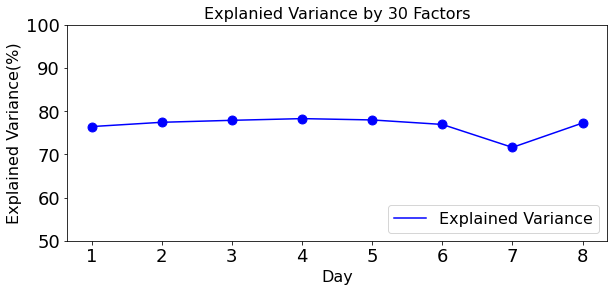

In [212]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18})
ListLegend = ['Explained Variance']
t_Day = np.arange(1,9,1)
fig = plt.figure(figsize=(10,4))
# since here we have one plot (and not subplots), the usage of these floats numbers are necessary rather than using 0 or 1 
ax = fig.add_axes([0.1,0.16,0.75,0.75])
ax.scatter(t_Day,factor_variance,s=80, c='b')
ax.plot(t_Day,factor_variance,'b', label=ListLegend[0])
ax.set_ylim([50,100])
ax.set_title('Explanied Variance by '+str(Dim)+' Factors',fontsize=16)
ax.set_xlabel('Day',fontsize=16)
ax.set_ylabel('Explained Variance(%)',fontsize=16)
ax.legend(loc=4,prop={'size': 16})
plt.savefig('ExplainedVariance_'+str(Dim)+'Factors.png',facecolor='w', transparent=False, dpi=300)

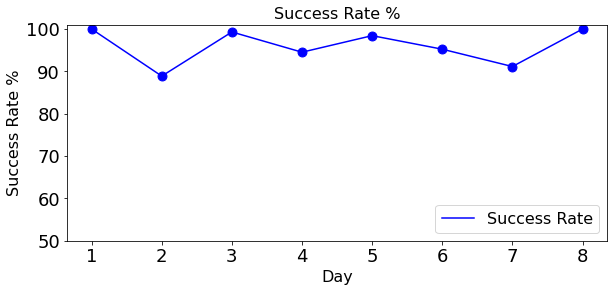

In [50]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

success_rate = []

for i in range(8): 
    success = (Day_NumTrial_T1[i]+Day_NumTrial_T2[i]+Day_NumTrial_T3[i]+Day_NumTrial_T4[i])/(Day_NumTrial_T1[i]+Day_NumTrial_T2[i]+Day_NumTrial_T3[i]+Day_NumTrial_T4[i]+Day_NumTrial_Fail_T1[i]+Day_NumTrial_Fail_T2[i]+Day_NumTrial_Fail_T3[i]+Day_NumTrial_Fail_T4[i])
    success_rate.append(100*success)

matplotlib.rcParams.update({'font.size': 18})
ListLegend = ['Success Rate']
t_Day = np.arange(1,9,1)
fig = plt.figure(figsize=(10,4))
# since here we have one plot (and not subplots), the usage of these floats numbers are necessary rather than using 0 or 1 
ax = fig.add_axes([0.1,0.16,0.75,0.75])
ax.scatter(t_Day,success_rate,s=80, c='b')
ax.plot(t_Day,success_rate,'b', label=ListLegend[0])
ax.set_ylim([50,101])
ax.set_title('Success Rate %',fontsize=16)
ax.set_xlabel('Day',fontsize=16)
ax.set_ylabel('Success Rate %',fontsize=16)
ax.legend(loc=4,prop={'size': 16})
plt.savefig('SuccessRate.png',facecolor='w', transparent=False, dpi=300)


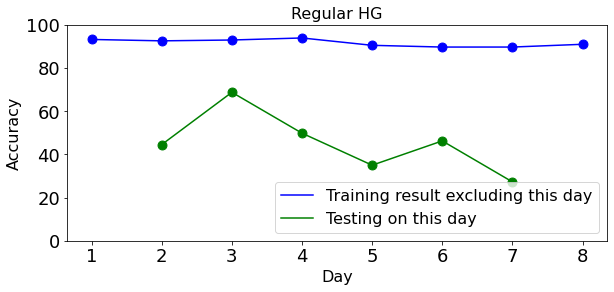

In [36]:
if Case_class == 1:
    import matplotlib
    import matplotlib.pyplot as plt
    %matplotlib inline
    #%matplotlib notebook
    matplotlib.rcParams.update({'font.size': 18})

    ListLegend = ['Training result excluding this day','Testing on this day']
    t_Day = np.arange(1,9,1)
    fig = plt.figure(figsize=(10,4))
    # since here we have one plot (and not subplots), the usage of these floats numbers are necessary rather than using 0 or 1 
    ax = fig.add_axes([0.1,0.16,0.75,0.75])
    ax.scatter(t_Day,accuracy_training,s=80, c='b')
    ax.plot(t_Day,accuracy_training,'b', label=ListLegend[0])
    if successful:        
        ax.scatter(t_Day,accuracy_holdout,s=80, c='r')
        ax.plot(t_Day,accuracy_holdout,'r',label=ListLegend[1])
        ax.set_ylim([50,100])
        ax.set_title('Regular HG',fontsize=16)
        ax.set_xlabel('Day',fontsize=16)
        ax.set_ylabel('Accuracy',fontsize=16)
        ax.legend(loc=4,prop={'size': 16})
        plt.savefig('Accuracies_RegularHG.png',facecolor='w', transparent=False, dpi=300)
    else:
        ax.scatter(t_Day,accuracy_holdout,s=80, c='g')
        ax.plot(t_Day,accuracy_holdout,'g',label=ListLegend[1])
        ax.set_ylim([0,100])
        ax.set_title('Regular HG',fontsize=16)
        ax.set_xlabel('Day',fontsize=16)
        ax.set_ylabel('Accuracy',fontsize=16)
        ax.legend(loc=4,prop={'size': 16})
        plt.savefig('Accuracies_RegularHG_Fail.png',facecolor='w', transparent=False, dpi=300)


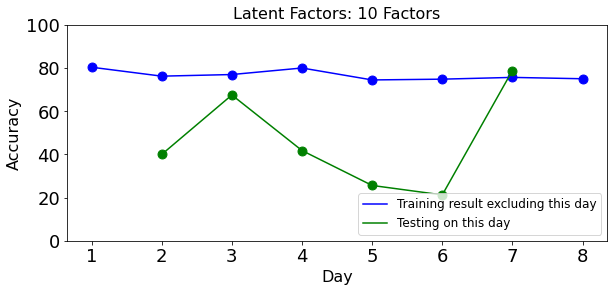

In [40]:
if Case_class == 2:
    import matplotlib
    import matplotlib.pyplot as plt
    %matplotlib inline
    #%matplotlib notebook
    matplotlib.rcParams.update({'font.size': 18})

    ListLegend = ['Training result excluding this day','Testing on this day']
    t_Day = np.arange(1,9,1)
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_axes([0.1,0.16,0.75,0.75])
    ax.scatter(t_Day,accuracy_training,s=80, c='b')
    ax.plot(t_Day,accuracy_training,'b', label=ListLegend[0])
    if successful:   
        ax.scatter(t_Day,accuracy_holdout,s=80, c='r')
        ax.plot(t_Day,accuracy_holdout,'r',label=ListLegend[1])
        ax.set_ylim([50,100])
        ax.set_title('Latent Factors: '+ str(Dim)+' Factors',fontsize=16)
        ax.set_xlabel('Day',fontsize=16)
        ax.set_ylabel('Accuracy',fontsize=16)
        ax.legend(loc=4,prop={'size': 16})
        plt.savefig('Accuracies_LatentFactors_'+str(Dim)+'Factors.png',facecolor='w', transparent=False, dpi=300)
    else:
        ax.scatter(t_Day,accuracy_holdout,s=80, c='g')
        ax.plot(t_Day,accuracy_holdout,'g',label=ListLegend[1])
        ax.set_ylim([0,100])
        ax.set_title('Latent Factors: '+ str(Dim)+' Factors',fontsize=16)
        ax.set_xlabel('Day',fontsize=16)
        ax.set_ylabel('Accuracy',fontsize=16)
        ax.legend(loc=4,prop={'size': 12})
        plt.savefig('Accuracies_LatentFactors_'+str(Dim)+'Factors_Fail.png',facecolor='w', transparent=False, dpi=300)


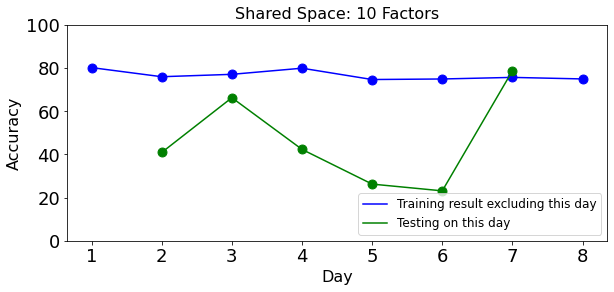

In [44]:
if Case_class == 3:
    import matplotlib
    import matplotlib.pyplot as plt
    %matplotlib inline
    #%matplotlib notebook
    matplotlib.rcParams.update({'font.size': 18})

    ListLegend = ['Training result excluding this day','Testing on this day']
    t_Day = np.arange(1,9,1)
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_axes([0.1,0.16,0.75,0.75])
    ax.scatter(t_Day,accuracy_training,s=80, c='b')
    ax.plot(t_Day,accuracy_training,'b', label=ListLegend[0])
    
    if successful:   
        ax.scatter(t_Day,accuracy_holdout,s=80, c='r')
        ax.plot(t_Day,accuracy_holdout,'r',label=ListLegend[1])
        ax.set_ylim([50,100])
        ax.set_title('Shared Space: '+str(Dim)+' Factors',fontsize=16)
        ax.set_xlabel('Day',fontsize=16)
        ax.set_ylabel('Accuracy',fontsize=16)
        ax.legend(loc=4,prop={'size': 16})
        plt.savefig('Accuracies_SharedSpace_'+str(Dim)+'Factors.png',facecolor='w', transparent=False, dpi=300)
    else:
        ax.scatter(t_Day,accuracy_holdout,s=80, c='g')
        ax.plot(t_Day,accuracy_holdout,'g',label=ListLegend[1])
        ax.set_ylim([0,100])
        ax.set_title('Shared Space: '+str(Dim)+' Factors',fontsize=16)
        ax.set_xlabel('Day',fontsize=16)
        ax.set_ylabel('Accuracy',fontsize=16)
        ax.legend(loc=4,prop={'size': 12})
        plt.savefig('Accuracies_SharedSpace_'+str(Dim)+'Factors_Fail.png',facecolor='w', transparent=False, dpi=300)
            

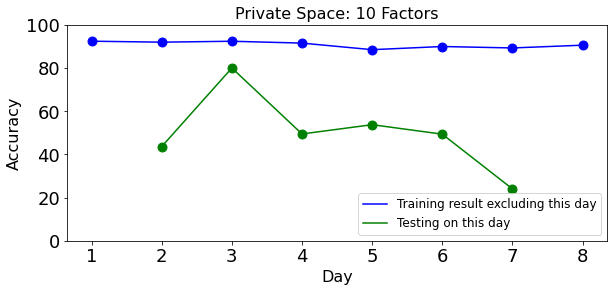

In [52]:
if Case_class == 4:
    import matplotlib
    import matplotlib.pyplot as plt
    %matplotlib inline
    #%matplotlib notebook
    matplotlib.rcParams.update({'font.size': 18})

    ListLegend = ['Training result excluding this day','Testing on this day']
    t_Day = np.arange(1,9,1)
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_axes([0.1,0.16,0.75,0.75])
    ax.scatter(t_Day,accuracy_training,s=80, c='b')
    ax.plot(t_Day,accuracy_training,'b', label=ListLegend[0])
    
    if successful: 
        ax.scatter(t_Day,accuracy_holdout,s=80, c='r')
        ax.plot(t_Day,accuracy_holdout,'r',label=ListLegend[1])
        ax.set_ylim([50,100])
        ax.set_title('Private Space: '+str(Dim)+' Factors',fontsize=16)
        ax.set_xlabel('Day',fontsize=16)
        ax.set_ylabel('Accuracy',fontsize=16)
        ax.legend(loc=4,prop={'size': 16})
        plt.savefig('Accuracies_PrivateSpace_'+str(Dim)+'Factors.png',facecolor='w', transparent=False, dpi=300)
    else:
        ax.scatter(t_Day,accuracy_holdout,s=80, c='g')
        ax.plot(t_Day,accuracy_holdout,'g',label=ListLegend[1])
        ax.set_ylim([0,100])
        ax.set_title('Private Space: '+str(Dim)+' Factors',fontsize=16)
        ax.set_xlabel('Day',fontsize=16)
        ax.set_ylabel('Accuracy',fontsize=16)
        ax.legend(loc=4,prop={'size': 12})
        plt.savefig('Accuracies_PrivateSpace_'+str(Dim)+'Factors_Fail.png',facecolor='w', transparent=False, dpi=300)
        

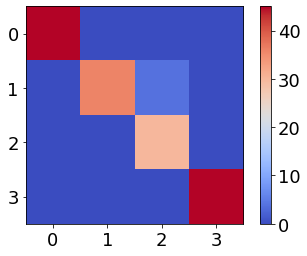

In [219]:
w = confusion_matrix(y_holdout, predictions_holdout_multi)
plt.imshow(w, cmap='coolwarm')
plt.colorbar()

#  Performing multi-classifier using other methods: ..., NN, ...